### Read Data and display features

In [5]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

data_directory_path: str = '/Users/muna/Development/DataScience/new-york-city-taxi-fare-prediction'
data_directory: [str] = os.listdir(data_directory_path)
print(data_directory)

train_df =  pd.read_csv(data_directory_path + "/train.csv", nrows = 55_000_000)
train_df.dtypes

['.DS_Store', 'test.csv', 'Taxi Fare Project.ipynb', 'GCP-Coupons-Instructions.rtf', 'Data Scienc Project Report.docx', 'DataScience-Taxi-', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

#### Create two new features in our training set 
- Call it "travel vector" between the start and end points of the taxi ride, both longitude and latitude coordinates. 
- Take the absolute value since we're only interested in distance traveled.

In [6]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


#### Prune outliers

In [9]:
print(train_df.isnull().sum())

print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
dtype: int64
Old size: 54999625
New size: 54999625


#### Plot distribution

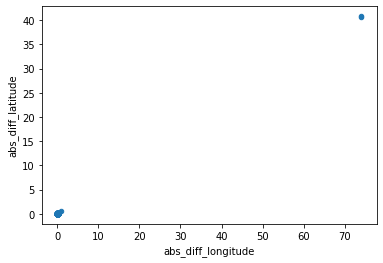

In [10]:
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')


#### Can remove values above 5 safely

In [11]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))


Old size: 54999625
New size: 54885953


#### Generate training feature and target

In [12]:
# Construct and return an Nx3 input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(54885953, 3)
(54885953,)


#### Find optimal weight using lstq

In [13]:
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

# Can also use Ordinary Least Squares method
# w=(XT⋅X)−1⋅XT⋅y
w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)
print(w_OLS)

[147.23823776  76.42855672   6.40935423]
[147.23823776  76.42855672   6.40935423]


#### Load Test input

In [14]:
test_df = pd.read_csv(data_directory_path + '/test.csv')
test_df.dtypes


key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [15]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

print(os.listdir('.'))

from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(train_X, train_y)

from sklearn import metrics
import numpy as np
y_prediction = linear_regression.predict(test_X)

mse = metrics.mean_squared_error(test_y_predictions, y_prediction)
rmse = np.sqrt(mse)
print(rmse)

['.DS_Store', 'DataScience-Taxi-.ipynb', 'submission.csv', 'README.md', '.gitignore', '.ipynb_checkpoints', '.git', 'bijan_taxi.ipynb']
0.0028867573702126546
